In [2]:
!pip install -U albumentations>=0.3.0 --user
!pip install -U segmentation-models
!pip install numpy==1.19.5

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!pip install -U tensorflow

In [3]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import os
import segmentation_models as sm
import albumentations as A
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Concatenate, Conv2DTranspose, BatchNormalization, Activation, DepthwiseConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import pandas as pd
from tqdm import tqdm
import keras

%matplotlib inline

Segmentation Models: using `keras` framework.


### Decoding RLEs into masks for training

In [4]:
def decode_rle_to_mask(rle, height, width, viz=False):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height * width, 1))
    if viz:
        color = np.random.rand(3)
    else:
        color = 1
    for i in rle:
        mask[int(i[0]) : int(i[0]) + int(i[1]), :] = color

    return mask.reshape(height, width).astype(np.float32)

In [5]:
data_path = os.path.join('/kaggle/input/Multiclass-segmentation')
train_path = os.path.join(data_path, 'TrainImages')
test_path = os.path.join(data_path, 'TestImages')

In [6]:
# Open train file
with open(os.path.join(data_path,'train.csv'), 'r', encoding='utf-8') as train:
    reader = csv.reader(train)
    # skip headers row
    next(reader)

    # pull the masks for the first image
    row = next(iter(reader))
    print(row[0])
    mask1 = decode_rle_to_mask(row[4], int(row[1]), int(row[2]))
    row = next(iter(reader))
    mask2 = decode_rle_to_mask(row[4], int(row[1]), int(row[2]))
    row = next(iter(reader))
    mask3 = decode_rle_to_mask(row[4], int(row[1]), int(row[2]))    

2008_006280


### Encoding masks into RLE for submission

In [7]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def mobilenet_v1_block(inputs, filters, filter_shape, stride=1):
    # Depthwise Convolution
    x = DepthwiseConv2D(kernel_size=filter_shape, strides=stride, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Pointwise Convolution
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def inception_block(input_tensor, filters):
    branch_1 = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(input_tensor)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = Activation('relu')(branch_1)

    branch_2 = mobilenet_v1_block(input_tensor, filters * 4, filter_shape=3)

    branch_3 = mobilenet_v1_block(input_tensor, filters, filter_shape=5)

    branch_4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch_4 = Conv2D(filters, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(branch_4)
    branch_4 = BatchNormalization()(branch_4)
    branch_4 = Activation('relu')(branch_4)

    x = Concatenate(axis=-1)([branch_1, branch_2, branch_3, branch_4])
    return x

In [ ]:
def conv_block(inputs, num_filters):
    num_filters /= 8

    # Convolutional layer with num_filters filters, kernel size of (3,3) and ReLU activation
    x = inception_block(inputs, num_filters)

    # Another convolutional layer with the same number of filters and activation function
    x = inception_block(x, num_filters)

    return x

def encoder_block(inputs, num_filters):
    # Apply a convolutional block
    x = conv_block(inputs, num_filters)
    # Apply a max pooling operation with pool size of (2,2) for downsampling
    pool = MaxPooling2D(pool_size=(2, 2))(x)
    # Return the output of the block and the pooled feature map
    return x, pool

def decoder_block(inputs, skip_features, num_filters):
    # Upsample the input using a transposed convolutional layer with stride (2,2)
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(inputs)
    # Concatenate the upsampled feature map with the corresponding skip connection
    x = Concatenate()([x, skip_features])
    # Apply a convolutional block with the same number of filters
    x = conv_block(x, num_filters)
    return x

def build_unet(input_tensor, num_classes):
    # Encoder path
    enc1, pool1 = encoder_block(input_tensor, 64)
    enc2, pool2 = encoder_block(pool1, 128)
    enc3, pool3 = encoder_block(pool2, 256)
    enc4, pool4 = encoder_block(pool3, 512)

    # Bottleneck
    bottleneck = conv_block(pool4, 1024)
    bottleneck = Dropout(0.5)(bottleneck)

    # Decoder path
    dec4 = decoder_block(bottleneck, enc4, 512)
    dec3 = decoder_block(dec4, enc3, 256)
    dec2 = decoder_block(dec3, enc2, 128)
    dec1 = decoder_block(dec2, enc1, 64)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax', kernel_initializer='he_normal')(dec1)

    # Create the model
    model = Model(inputs=input_tensor, outputs=outputs)
    return model

inputs = Input((256, 256, 3))
model = build_unet(inputs, 4)

model.summary()

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=False,
    layer_range=None,
    show_layer_activations=True
)

In [8]:
train_df = pd.read_csv('/kaggle/input/Multiclass-segmentation/train.csv')

In [9]:
train_df.ImageName = train_df.ImageName + '.jpg'

In [10]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.2)

In [11]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """

    CLASSES = ['head', 'body', 'legs', 'tail']

    def __init__(
            self,
            images_dir,
            masks_df,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = np.unique(masks_df['ImageName'])
        self.masks_df = masks_df
        self.images_dir = images_dir
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # read data
        image_name = self.masks_df.ImageName.iloc[i]
        image = cv2.imread(os.path.join(self.images_dir, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        temp = self.masks_df[self.masks_df.ImageName == image_name]
        height = temp.ImageHeight[temp.ImageName == image_name].iloc[0]
        width = temp.ImageWidth[temp.ImageName == image_name].iloc[0]
        if temp.empty:
            mask = np.zeros((height, width))
        else:
            mask = temp.ClassNumber[temp.ImageName == image_name].iloc[0] * decode_rle_to_mask(temp.Encoding[temp.ImageName == image_name].iloc[0], height, width)
            for i in range(1, len(temp)):
                mask += temp.ClassNumber[temp.ImageName == image_name].iloc[i] * decode_rle_to_mask(temp.Encoding[temp.ImageName == image_name].iloc[i], height, width)


        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

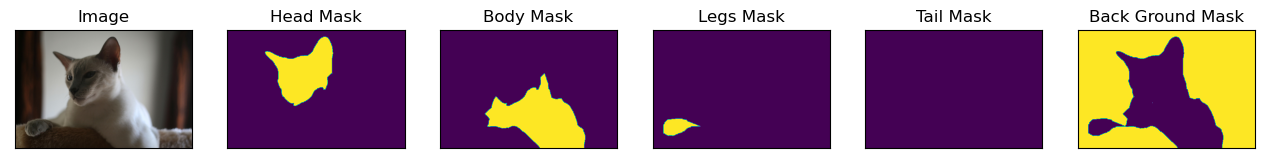

In [12]:
# Lets look at data we have
dataset = Dataset(train_path, train, classes=['head', 'body', 'legs', 'tail'])

image, mask = dataset[10] # get some sample
visualize(
    image=image, 
    head_mask=mask[..., 1].squeeze(),
    body_mask=mask[..., 2].squeeze(),
    legs_mask=mask[..., 3].squeeze(),
    tail_mask=mask[..., 4].squeeze(),
    back_ground_mask=mask[..., 0].squeeze(),
)

In [13]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=224, min_width=224, always_apply=True, border_mode=0),
        A.RandomCrop(height=224, width=224, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(224, 224),
        A.augmentations.geometric.resize.Resize (224, 224, always_apply=True)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1151: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albument

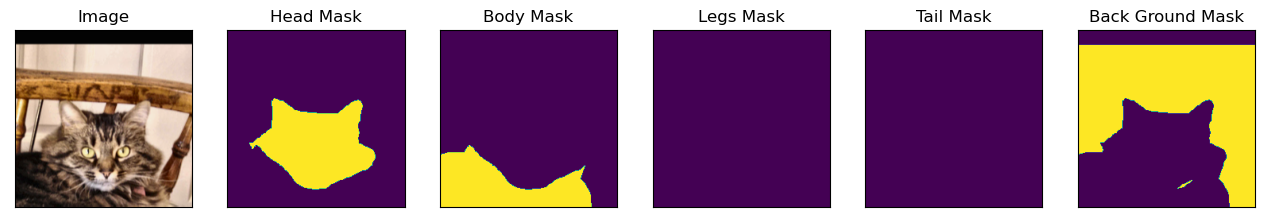

In [14]:
dataset = Dataset(train_path, train, classes=['head', 'body', 'legs', 'tail'], augmentation=get_training_augmentation())

image, mask = dataset[310] # get some sample
visualize(
    image=image, 
    head_mask=mask[..., 1].squeeze(),
    body_mask=mask[..., 2].squeeze(),
    legs_mask=mask[..., 3].squeeze(),
    tail_mask=mask[..., 4].squeeze(),
    back_ground_mask=mask[..., 0].squeeze(),
)

In [15]:
BATCH_SIZE = 16
LR = 0.0001
EPOCHS = 40
CLASSES = ['head', 'body', 'legs', 'tail']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation

# define optomizer
optimizer = Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (head: 0.5; body: 0.5; leg: .5; tail: 0.3; background: 0.1)
total_loss = sm.losses.categorical_focal_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = ['acc', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [16]:
BACKBONE = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(BACKBONE)

efficientnet_model = sm.Unet(BACKBONE, classes=n_classes, activation='softmax')
efficientnet_model.load_weights('/kaggle/input/eff-model/best_model.h5')


71892840/71892840 [==============================] - 2s 0us/step


In [ ]:
BACKBONE = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(BACKBONE)

efficientnet_model = sm.Unet(BACKBONE, classes=n_classes, activation='softmax', encoder_weights='imagenet')

efficientnet_model.compile(optimizer, loss=total_loss, metrics=metrics)
# efficientnet_model.summary()

In [17]:
# Dataset for train images
train_dataset = Dataset(
    train_path, 
    train, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    train_path,
    val,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [19]:
# next(iter(valid_dataloader))[0].shape

print(len(train_dataloader))
print(len(valid_dataloader))


133
1080


In [ ]:
# for i,j  in valid_dataloader:
#     print(j.shape)

In [ ]:
efficientnet_model.summary()

In [ ]:
history = efficientnet_model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader)
)

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
test_df = pd.read_csv('/kaggle/input/Multiclass-segmentation/test_class.csv')
test_df.ImageName += '.jpg'
test_images = [f for f in os.listdir('/kaggle/input/Multiclass-segmentation/TestImages')]
# submission = pd.read_csv('/kaggle/input/Multiclass-segmentation/Sample Submission.csv')

In [35]:
test_df.shape

(3088, 5)

In [36]:
len(np.unique(test_df.ImageName))

932

In [29]:
test_masks = pd.DataFrame(columns=["ImageName","ClassNumber","Encoding"])

for id in test_df.ImageName:
    image = np.expand_dims(
    cv2.cvtColor(
            cv2.resize(
                cv2.imread(
                    os.path.join(test_path, id)
                ), (224, 224)
            ), cv2.COLOR_BGR2RGB
        ), 0
    )
    prediction = efficientnet_model.predict(image)
    if (np.unique(prediction) == [0.]).all():
        test_masks.loc[len(test_masks.index)] = [id,i,encode_mask_to_rle(prediction[..., 0])]
        continue
    masks = []
    masks.append(prediction[..., 0])
    masks.append(prediction[..., 1])
    masks.append(prediction[..., 2])
    masks.append(prediction[..., 3])
    masks.append(prediction[..., 4])
#     for i,mask in enumerate(masks):
#         if (np.unique(prediction) == [0.]).any():
#             continue
#         else:
#             test_masks.loc[len(test_masks.index)] = [id,i,encode_mask_to_rle(mask)]

1/1 [==============================] - 0s 62ms/step


KeyboardInterrupt: 

In [ ]:
test_masks

In [33]:
test_df.head()

,ImageName,ImageWidth,ImageHeight,ClassNumber,Encoding
0,2008_000008.jpg,442,500,1,NaN
1,2008_000008.jpg,442,500,2,NaN
2,2008_000008.jpg,442,500,3,NaN
3,2008_000008.jpg,442,500,4,NaN
4,2008_000009.jpg,375,500,1,NaN


In [ ]:
for x in prediction[...,:]:
    print(x.shape)

1/1 [==============================] - 0s 36ms/step


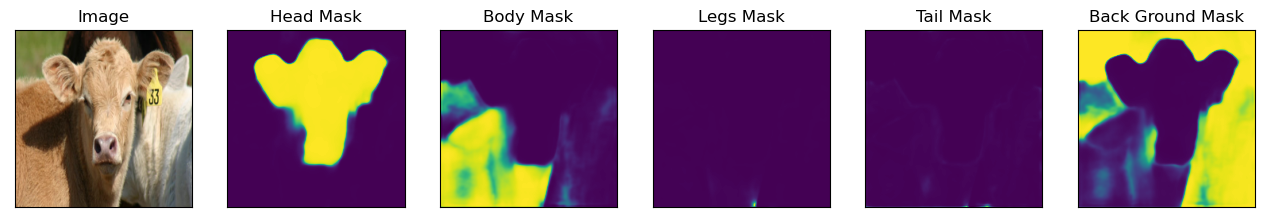

1/1 [==============================] - 0s 36ms/step


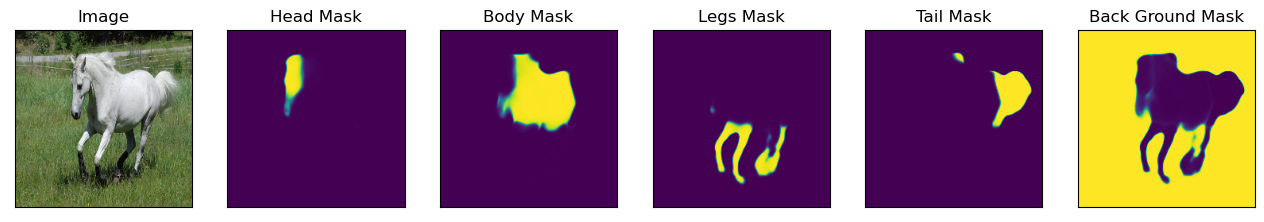

1/1 [==============================] - 0s 37ms/step


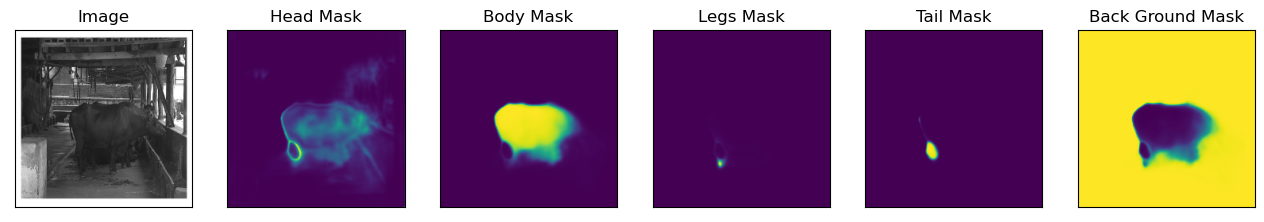

1/1 [==============================] - 0s 35ms/step


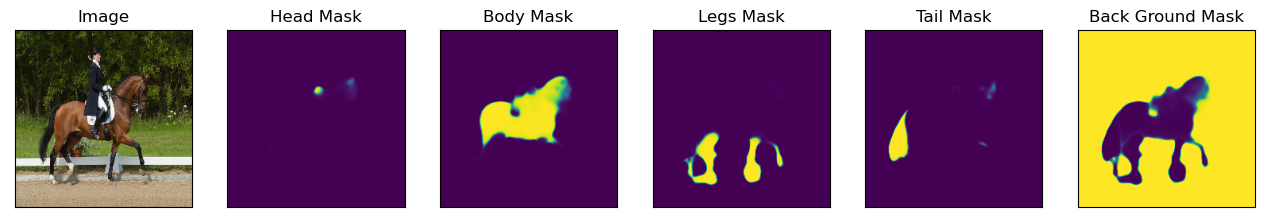

1/1 [==============================] - 0s 36ms/step


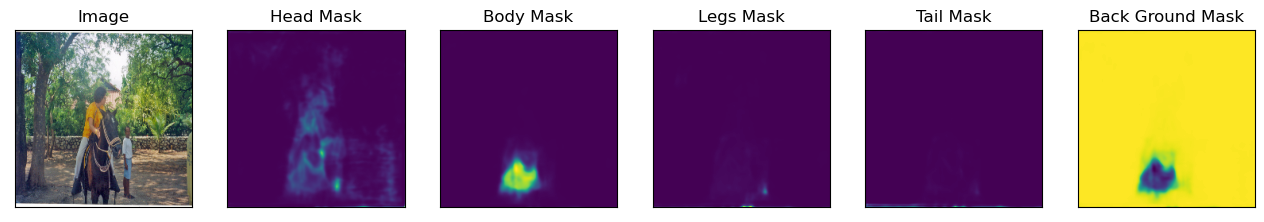

1/1 [==============================] - 0s 46ms/step


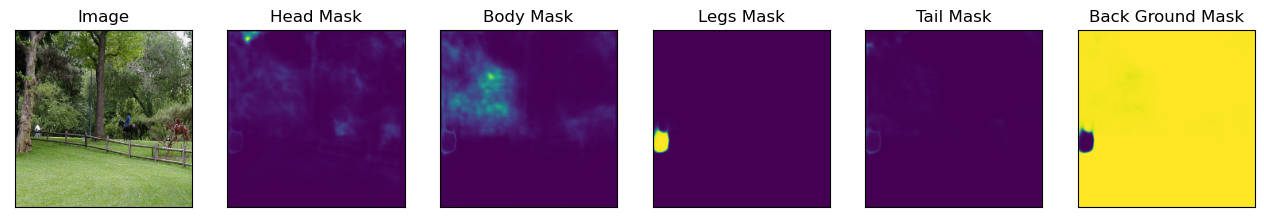

1/1 [==============================] - 0s 55ms/step


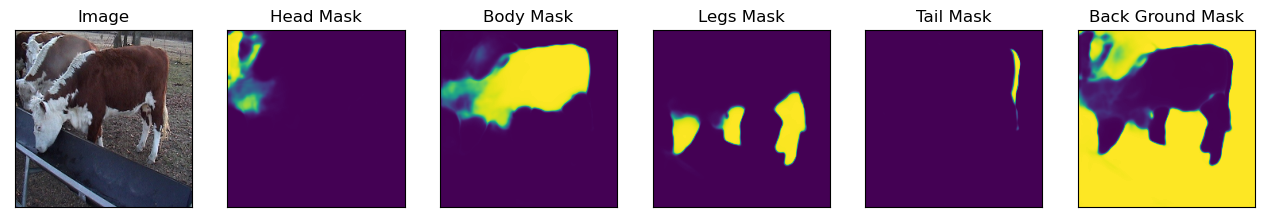

1/1 [==============================] - 0s 36ms/step


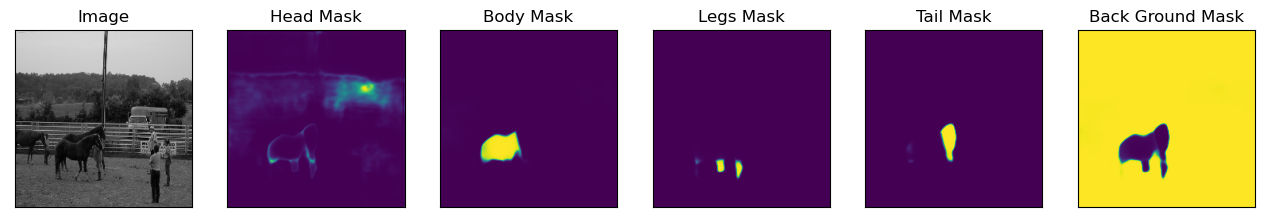

1/1 [==============================] - 0s 40ms/step


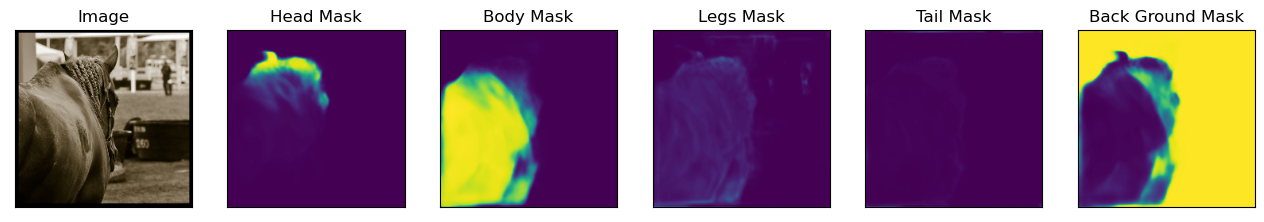

1/1 [==============================] - 0s 38ms/step


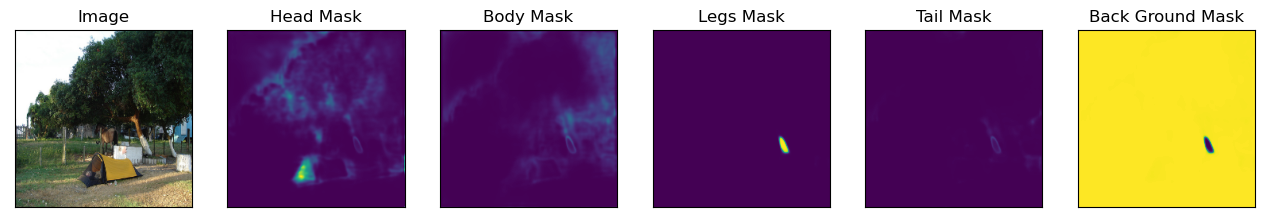

In [37]:
ids = np.unique(test_df.ImageName)[-10:]

for id in ids:
    image = np.expand_dims( 
        cv2.resize(
            cv2.cvtColor(
                cv2.imread(os.path.join(test_path, id)),
                cv2.COLOR_BGR2RGB
            ),
            (224, 224)
        ),
        0
    )
    image2 = preprocess_input(image)
    prediction = efficientnet_model.predict(image2)
    visualize(
        image=image[0], 
        head_mask=prediction[..., 1].squeeze(),
        body_mask=prediction[..., 2].squeeze(),
        legs_mask=prediction[..., 3].squeeze(),
        tail_mask=prediction[..., 4].squeeze(),
        back_ground_mask=prediction[..., 0].squeeze(),
    )

In [ ]:
BACKBONE = 'inceptionresnetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)
inc_resnet_model = sm.Unet(BACKBONE, classes=4, activation='softmax', encoder_weights='imagenet')

inc_resnet_model.compile(optimizer, loss=(total_loss), metrics=metrics)
# inc_resnet_model.summary()

In [ ]:
history = inc_resnet_model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader)
)

In [ ]:
950 - 960